In [167]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchshow as ts
import torchmetrics
import matplotlib.pyplot as plt

In [168]:
# Importere dataset, kun træning indtil videre.
training_images = MNIST(root='data', transform=ToTensor(), train=True)
training_dataloader = DataLoader(training_images, batch_size=1000)
testing_images = MNIST(root='data', transform=ToTensor(), train=False)
testing_dataloader = DataLoader(testing_images, batch_size=1000)

In [169]:
# Laver det Neurale Netværk, og opstiller et accuracy objekt til at måle hvor god modellen er.
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
net = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=3), #første parameter 1 er antal kanaler, her 1 fordi vi arbejder med gråtoner; 12 er antal ouputkanaler, altså antal filtre; 3 er størrelsen på det udsnit af billedet vi tager, som så bliver 3x3 matrice af pixels.
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), #vælger den maksimale værdi i et udsnit af størrelsen 2x2, således dimensionerne af dataene reduceres fra 28x28 til 14x14
    nn.Conv2d(10, 10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), #vælger den maksimale værdi i et udsnit af størrelsen 2x2, således dimensionerne af dataene reduceres fra 14x14 til 7x7
    nn.Flatten(),
    nn.Linear(250,10), # input er nu 5 x 5 x 10
)
# Bruger crossentropy til at udregne losset, og indstiller optimizeren.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, maximize=False)

In [170]:
# Loop'er over 10 epoker, og udregner loss'et og accuracy for hvert.
def training_loop(training_dataloader, optimizer, loss_fn):
    total_loss = 0
    accuracy.reset()
    size = len(training_dataloader)
    for images,labels in training_dataloader:
        optimizer.zero_grad()
        output = net(images)
        loss = loss_fn(output, labels)
        total_loss += loss
        loss.backward()
        optimizer.step()
        accuracy.update(output, labels)
    avg_loss = total_loss / size
    print(f"Avg Training Accuracy: {accuracy.compute() * 100:.2f}%")
    print(f"Avg Training Loss: {avg_loss}")

def testing_loop(testing_dataloader, loss_fn):
    total_loss = 0
    accuracy.reset()
    size = len(testing_dataloader)
    with torch.no_grad():
        for images,labels in testing_dataloader:
            output = net(images)
            loss = loss_fn(output, labels)
            total_loss += loss
            accuracy.update(output,labels)
    avg_loss = total_loss / size
    print(f"Avg Testing Accuracy: {accuracy.compute() * 100 :.2f}%")
    print(f"Avg Testing Loss: {avg_loss}")

In [171]:
for i in range(40):
    print(f"Epoch: {i}")
    testing_loop(testing_dataloader, loss_fn)
    training_loop(training_dataloader, optimizer, loss_fn)
    print("------------------")

Epoch: 0
Avg Testing Accuracy: 10.44%
Avg Testing Loss: 2.3038954734802246
Avg Training Accuracy: 82.80%
Avg Training Loss: 0.6052076816558838
------------------
Epoch: 1
Avg Testing Accuracy: 95.43%
Avg Testing Loss: 0.15775389969348907
Avg Training Accuracy: 95.85%
Avg Training Loss: 0.1382410228252411
------------------
Epoch: 2
Avg Testing Accuracy: 96.91%
Avg Testing Loss: 0.09846438467502594
Avg Training Accuracy: 97.06%
Avg Training Loss: 0.09712325036525726
------------------
Epoch: 3
Avg Testing Accuracy: 97.55%
Avg Testing Loss: 0.08169470727443695
Avg Training Accuracy: 97.50%
Avg Training Loss: 0.08166242390871048
------------------
Epoch: 4
Avg Testing Accuracy: 97.79%
Avg Testing Loss: 0.07333729416131973
Avg Training Accuracy: 97.78%
Avg Training Loss: 0.07262850552797318
------------------
Epoch: 5
Avg Testing Accuracy: 97.80%
Avg Testing Loss: 0.06652777642011642
Avg Training Accuracy: 97.93%
Avg Training Loss: 0.06628532707691193
------------------
Epoch: 6
Avg Testin

KeyboardInterrupt: 

Model output:
tensor([[ -4.76621, -16.68670,  -5.65210,  -7.28237,  -0.45005,   9.25993,
          11.49490, -13.85319,  -0.61805,  -0.41987]],
       grad_fn=<AddmmBackward0>)
Efter softmax:
tensor([[7.82960e-08, 5.20877e-13, 3.22850e-08, 6.32387e-09, 5.86441e-06,
         9.66523e-02, 9.03331e-01, 8.85756e-12, 4.95750e-06, 6.04409e-06]],
       grad_fn=<SoftmaxBackward0>)
Modul bud: 6
Korrekt: 5


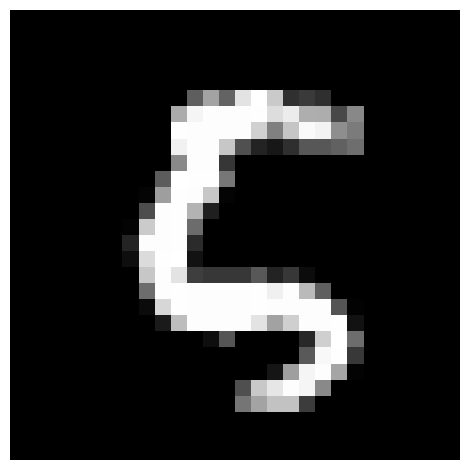

In [172]:
# Afprøver modellen på et givent index af billederne.
img_idx = 2000
pred = net(training_images[img_idx][0].unsqueeze(0)) 
print("Model output:")
print(pred)
sm = nn.Softmax(dim=1)
print("Efter softmax:")
print(sm(pred))
print(f"Modul bud: {pred.argmax()}")
print(f"Korrekt: {training_images[img_idx][1]}")
ts.show(training_images[img_idx][0])

0
1
2
3
4
5
6
7
8
4


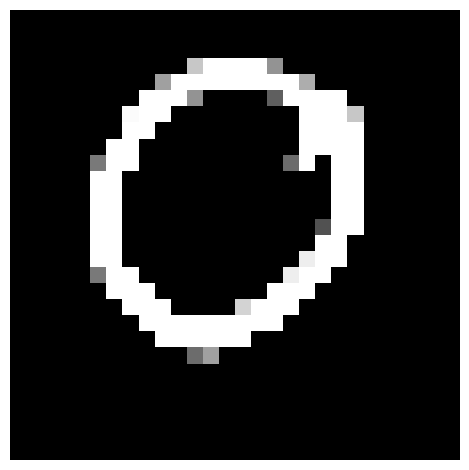

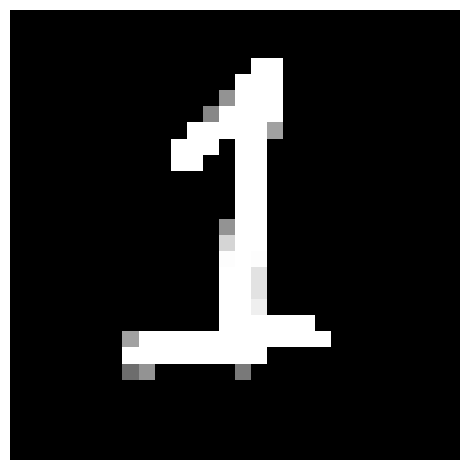

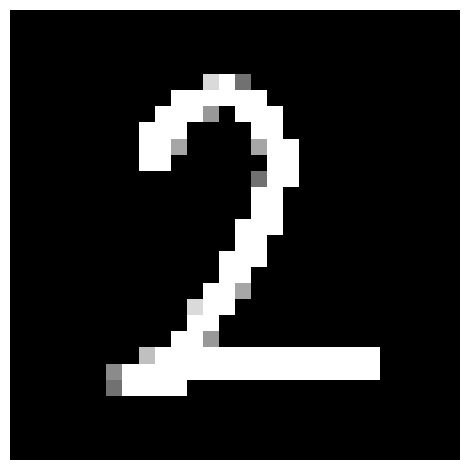

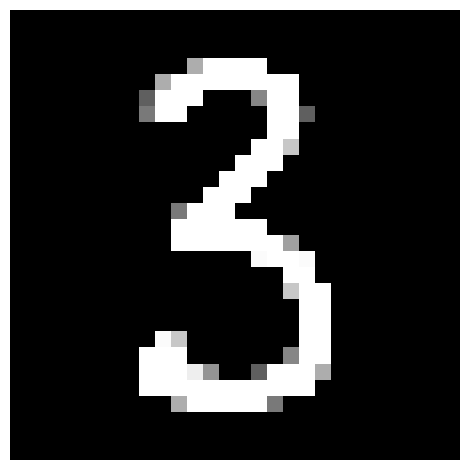

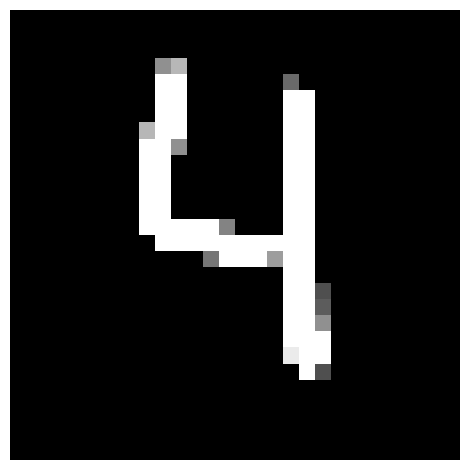

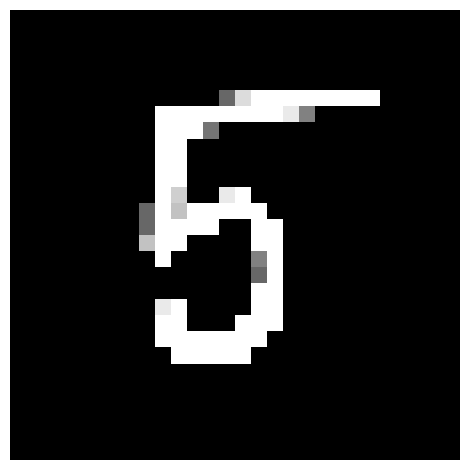

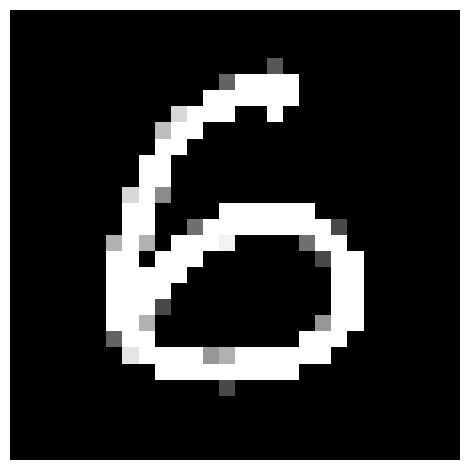

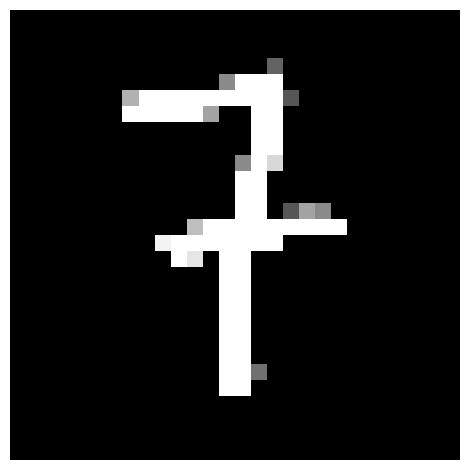

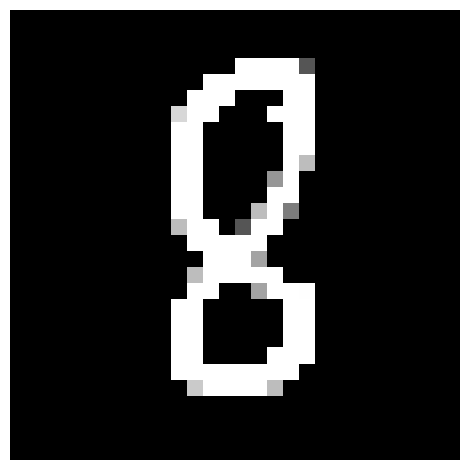

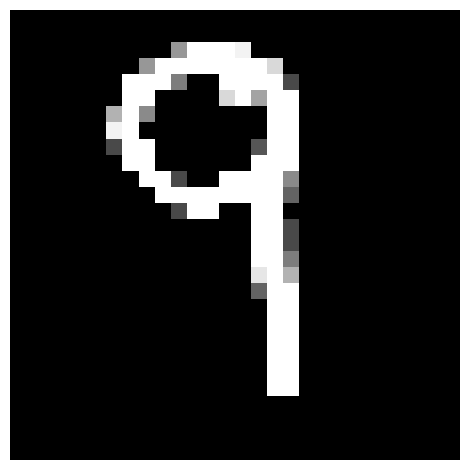

In [174]:

# Pytorch Documentation og Mikkels ting
def preprocess(image):
    gs = torchvision.transforms.Grayscale(num_output_channels=1)
    image = image[0:3]
    image = torchvision.transforms.functional.resize(image, [28, 28], antialias=True)
    image = gs(image)
    image = image.float()/255
    image = torchvision.transforms.functional.invert(image)
    image = torchvision.transforms.functional.adjust_contrast(image, 13)
    tresh = torch.nn.Threshold(0.28, 0.0)
    image = tresh(image)
    return image

for i in range(10):
    image = torchvision.io.decode_image(f"far_images/image{10+i}.png")
    image = preprocess(image)
    ts.show(image)
    image = image.unsqueeze(0)
    print(net(image).argmax().item())
    sm(net(image))